In [3]:
import numpy as np
import cv2
import time
import pandas as pd
from matplotlib import pyplot as plt 

### Define the functions for optical flow

In [4]:
def draw_flow(img, flow, step=16):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr


def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr


def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


### Suppy video file path

In [5]:
path = r"C:\Users\lucki\WORK\UMBC\FoodVR\data\877VR_B_Trim1.MP4"

# Uncap the video processing to run faster
cap = cv2.VideoCapture(path)
# cap.set(cv2.CAP_PROP_FPS, 30)
cap.isOpened()

# Downscale the video to get less key points and less processing time
try:
    suc, prev = cap.read()
    prev = rescale_frame(prev, percent=10)
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
except:
    pass

##### Farneback optical flow calculation

In [6]:
rawOuput = []

try:
    while True:

        suc, img = cap.read()
        img = rescale_frame(img, percent=10)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # start time to calculate FPS
        start = time.time()


        flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        rawOuput.append([mag, ang])
        prevgray = gray


        # End time
        end = time.time()
        # calculate the FPS for current frame detection
        fps = 1 / (end-start)

        print(f"{fps:.2f} FPS")

        cv2.imshow('flow', draw_flow(gray, flow))
        cv2.imshow('flow HSV', draw_hsv(flow))


        key = cv2.waitKey(5)
        if key == ord('q'):
            break

except:
    pass

cap.release()
cv2.destroyAllWindows()

200.03 FPS
200.12 FPS
249.99 FPS
199.92 FPS
250.00 FPS
333.78 FPS
199.98 FPS
333.09 FPS
249.77 FPS
250.00 FPS
332.78 FPS
250.03 FPS
249.97 FPS
333.38 FPS
249.91 FPS
333.70 FPS
249.99 FPS
250.15 FPS
249.87 FPS
250.21 FPS
250.00 FPS
250.00 FPS
249.88 FPS
333.46 FPS
250.02 FPS
249.94 FPS
249.96 FPS
250.17 FPS
199.92 FPS
250.06 FPS
333.62 FPS
333.33 FPS
250.09 FPS
249.88 FPS
199.97 FPS
249.97 FPS
333.38 FPS
249.99 FPS
250.11 FPS
249.96 FPS
249.90 FPS
333.07 FPS
250.12 FPS
250.11 FPS
333.28 FPS
333.36 FPS
250.17 FPS
333.41 FPS
249.99 FPS
333.33 FPS
333.17 FPS
250.29 FPS
250.05 FPS
249.75 FPS
333.15 FPS
333.20 FPS
250.23 FPS
166.59 FPS
249.97 FPS
249.96 FPS
200.03 FPS
250.08 FPS
333.33 FPS
250.08 FPS
250.02 FPS
249.78 FPS
250.05 FPS
333.12 FPS
199.98 FPS
250.12 FPS
249.81 FPS
249.90 FPS
250.21 FPS
249.85 FPS
249.85 FPS
249.94 FPS
250.06 FPS
250.02 FPS
200.11 FPS
250.12 FPS
333.38 FPS
333.38 FPS
333.30 FPS
249.93 FPS
250.05 FPS
249.88 FPS
250.09 FPS
250.12 FPS
250.00 FPS
333.28 FPS
249.85 FPS

### Processing the raw data points

In [7]:
df = pd.DataFrame(rawOuput, columns=['mag', 'ang'])

In [8]:
df['mean'] = df['mag'].apply(lambda x: np.mean(x))
df['std'] = df['mag'].apply(lambda x: np.std(x))

meanList = df['mean'].tolist()
stdList = df['std'].tolist()

mean_per_second = np.add.reduceat(meanList, np.arange(0, len(meanList), 30))
std_per_second = np.add.reduceat(stdList, np.arange(0, len(stdList), 30))

#### PLotting mean and standard deviation of the optical flow

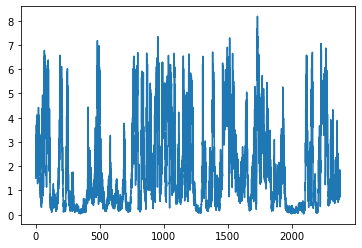

In [13]:
# mean per frame
plt.plot(meanList)

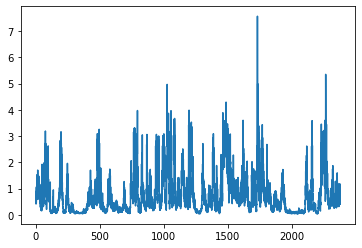

In [14]:
# std per frame
plt.plot(stdList)

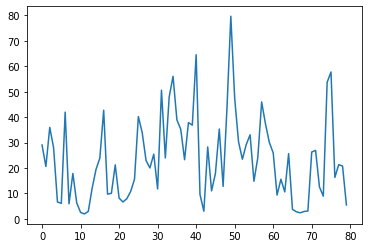

In [15]:
# std per second
plt.plot(std_per_second)

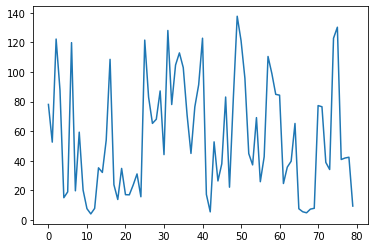

In [16]:
# mean per second
plt.plot(mean_per_second)

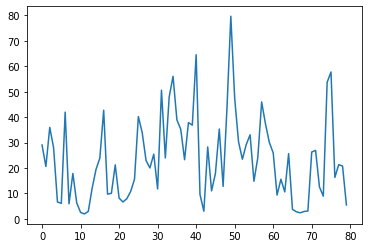

In [17]:
# Backfill the missing values

plt.plot(pd.DataFrame(std_per_second).fillna(method="ffill"))